In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def aproximacao_polinomial_mq(pontos, grau: int):
    """
    Ajuste polinomial por mínimos quadrados usando apenas NumPy.

    Parâmetros
    ----------
    pontos : array-like
        Array 2 x k com dados de entrada.
        Linha 0 contém x.
        Linha 1 contém y.
        Pode ser lista de listas ou np.ndarray.
    grau : int
        Grau do polinômio esperado (inteiro ≥ 0).

    Retorna
    -------
    np.ndarray
        Array de forma (grau + 1,) com os coeficientes do polinômio
        em ordem decrescente [a_n ... a_1 a_0].

    Observação
    ----------
    Se `pontos` não tiver pelo menos duas linhas, o acesso `pontos[1]`
    vai falhar. Seu docstring diz para levantar ValueError nesse caso;
    aqui mantive o comportamento original (como você pediu).
    """
    x = np.asarray(pontos[0], dtype=float)
    y = np.asarray(pontos[1], dtype=float)

    if x.size != y.size:
        raise ValueError(
            "pontos deve ter duas linhas com o mesmo numero de colunas"
        )

    if grau < 0:
        raise ValueError("grau deve ser inteiro nao negativo")

    X = np.vander(x, N=grau + 1, increasing=False)
    alpha_desc = np.linalg.lstsq(X, y, rcond=None)[0]

    return alpha_desc


def plotar_aprox_pol_mq(pontos, grau: int):
    """
    Gera o gráfico do ajuste polinomial por mínimos quadrados
    e retorna os coeficientes.
    """
    polinomio = aproximacao_polinomial_mq(pontos, grau)
    x = np.asarray(pontos[0], dtype=float).ravel()
    y = np.asarray(pontos[1], dtype=float).ravel()

    n_grid = max(100, int(round(max(x) - min(x)) * 100))
    x_pred = np.linspace(min(x), max(x), n_grid)
    y_pred = np.polyval(polinomio, x_pred)

    plt.scatter(x, y, label="dados", s=30)
    plt.plot(x_pred, y_pred, label="polinomio", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    return polinomio


def aproximacao_polinomial_aleatoria(
    pontos,
    grau: int,
    expoente: int = 3,
    intervalo=(0.0, 1.0),
    seed=None,
):
    """
    Busca aleatória de coeficientes polinomiais para aproximar os dados.

    Útil para comparação visual e para estudos de heurísticas.
    Não garante ótimo global.
    """
    _ = np.asarray(pontos[0], dtype=float).ravel()
    _ = np.asarray(pontos[1], dtype=float).ravel()

    tentativas = 10 ** expoente
    low, high = float(intervalo[0]), float(intervalo[1])

    rng = np.random.default_rng(seed)

    melhor_erro = None
    melhor_alpha = None
    n_coef = grau + 1

    for _ in range(tentativas):
        alpha = rng.uniform(low, high, size=n_coef)
        # voltando ao comportamento original:
        erro = SSR(pontos, alpha)

        if melhor_erro is None or erro < melhor_erro:
            melhor_erro = erro
            melhor_alpha = alpha.copy()

    return melhor_alpha


def plotar_aprox_pol_ale(
    pontos,
    grau: int,
    expoente: int = 3,
    intervalo=(-1.0, 1.0),
    seed=None,
):
    """
    Gera o gráfico da aproximação obtida por busca aleatória
    e retorna os coeficientes.
    """
    polinomio = aproximacao_polinomial_aleatoria(
        pontos,
        grau,
        expoente,
        intervalo,
        seed,
    )
    x = np.asarray(pontos[0], dtype=float).ravel()
    y = np.asarray(pontos[1], dtype=float).ravel()

    n_grid = max(100, int(round(max(x) - min(x)) * 100))
    x_pred = np.linspace(min(x), max(x), n_grid)
    y_pred = np.polyval(polinomio, x_pred)

    plt.scatter(x, y, label="dados", s=30)
    plt.plot(x_pred, y_pred, label="polinomio", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    return polinomio


def aproximacao_exponencial(pontos):
    """
    Ajuste exponencial do tipo y = c * exp(bx).

    Usa logaritmo natural e regressão linear via função de
    ajuste polinomial.

    ATENÇÃO
    -------
    Se algum y <= 0, np.log(y) vai dar erro ou -inf. Mantive o comportamento.
    """
    x = np.asarray(pontos[0], dtype=float).ravel()
    y = np.asarray(pontos[1], dtype=float).ravel()

    y_ln = np.log(y)
    dados = np.vstack((x, y_ln))
    coef_ln = aproximacao_polinomial_mq(dados, 1)

    b = coef_ln[0]
    c = np.exp(coef_ln[1])

    return np.array([c, b])


def plotar_aprox_exponencial(pontos):
    """
    Gera o gráfico do ajuste exponencial y = c * exp(bx)
    e retorna os parâmetros.
    """
    params = aproximacao_exponencial(pontos)
    c, b = params

    x = np.asarray(pontos[0], dtype=float).ravel()
    y = np.asarray(pontos[1], dtype=float).ravel()

    n_grid = max(100, int(round(max(x) - min(x)) * 100))
    x_pred = np.linspace(min(x), max(x), n_grid)
    y_pred = c * np.exp(b * x_pred)

    plt.scatter(x, y, label="dados", s=30)
    plt.plot(x_pred, y_pred, label="exponencial", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    return params


def SSR(pontos, polinomio):
    """
    Soma dos quadrados dos resíduos.
    """
    X = np.asarray(pontos[0], dtype=float)
    Y = np.asarray(pontos[1], dtype=float)

    y_aprox = np.polyval(polinomio, X)
    A = np.power((Y - y_aprox), 2)
    ssr = np.sum(A)

    return ssr


def SST(pontos):
    """
    Soma total dos quadrados.
    """
    Y = np.asarray(pontos[1], dtype=float)
    med = np.mean(Y)
    A = np.power((Y - med), 2)
    sst = np.sum(A)

    return sst


def R2(pontos, polinomio):
    """
    Coeficiente de determinação R².
    """
    return 1 - SSR(pontos, polinomio) / SST(pontos)


In [18]:
# EXEMPLO 1: ajuste polinomial por mínimos quadrados (grau 2)
import numpy as np

# dados (x, y)
x = np.array([0.0, 1.0, 2.0, 3.0])
y = np.array([1.0, 2.0, 0.0, 5.0])
pontos = (x, y)

coef = aproximacao_polinomial_mq(pontos, grau=2)
print("Coeficientes (grau 2):", coef)

r2 = R2(pontos, coef)
print("R²:", r2)


Coeficientes (grau 2): [ 1.  -2.   1.5]
R²: 0.6428571428571428


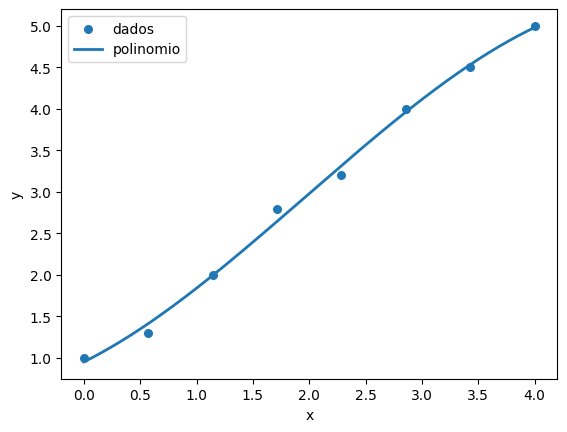

Coeficientes do polinômio: [-0.04330808  0.25620265  0.67569444  0.95151515]


In [20]:
# EXEMPLO 2: plot do ajuste polinomial
import numpy as np

x = np.linspace(0, 4, 8)
y = np.array([1.0, 1.3, 2.0, 2.8, 3.2, 4.0, 4.5, 5.0])
pontos = (x, y)

# abre uma janela com o gráfico
coef = plotar_aprox_pol_mq(pontos, grau=3)
print("Coeficientes do polinômio:", coef)


In [21]:
# EXEMPLO 3: busca aleatória de polinômio e comparação de erro
import numpy as np

# dados
x = np.linspace(-1, 1, 10)
y = 2 * x**2 + 0.5 * x + 1.0  # dado gerado de um polinômio
pontos = (x, y)

# solução por MQ
coef_mq = aproximacao_polinomial_mq(pontos, grau=2)
erro_mq = SSR(pontos, coef_mq)

# solução "chutando" coeficientes
coef_ale = aproximacao_polinomial_aleatoria(
    pontos,
    grau=2,
    expoente=3,          # 10^3 tentativas
    intervalo=(-2, 2),
    seed=42,
)
erro_ale = SSR(pontos, coef_ale)

print("Coef MQ:", coef_mq, "  SSR MQ:", erro_mq)
print("Coef aleatório:", coef_ale, "  SSR aleatório:", erro_ale)


Coef MQ: [2.  0.5 1. ]   SSR MQ: 1.4791141972893971e-31
Coef aleatório: [1.79458199 0.30744383 1.22476386]   SSR aleatório: 0.40441234984450236


Parâmetros (c, b): [3.  0.8]


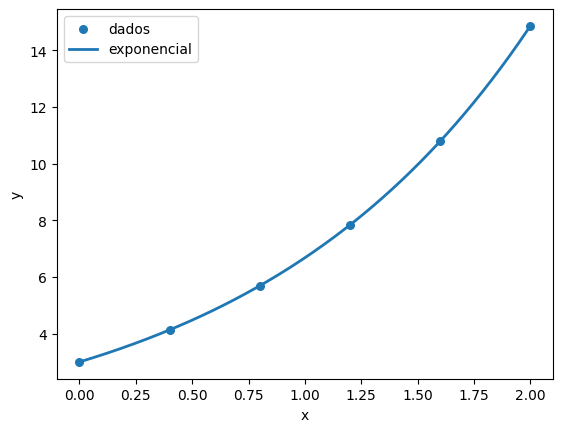

array([3. , 0.8])

In [22]:
# EXEMPLO 4: ajuste exponencial y = c * exp(bx) e plot
import numpy as np

# gerar dados exponenciais positivos
x = np.linspace(0, 2, 6)
y = 3.0 * np.exp(0.8 * x)  # c = 3, b = 0.8
pontos = (x, y)

params = aproximacao_exponencial(pontos)
print("Parâmetros (c, b):", params)

# mostra o gráfico comparando pontos e curva
plotar_aprox_exponencial(pontos)
